In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from src.onnx_model import YoloOnnxModel
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torch import nn
import cv2
import torch
from ultralytics import YOLO
import onnxruntime as ort
import torchvision
from src.utils.vision import non_maximum_supression
from src.visualization import plot_yolo_labels
from src.transforms import xywh2xyxy, xywhn2xywh

In [3]:
CONF_THRESHOLD = 0.25
IOU_THRESHOLD = 0.

onnx_model = YoloOnnxModel("../models/detection_model.onnx")

/home/shate/.cache/pypoetry/virtualenvs/digits-detection-hppNHGvS-py3.11/lib/python3.11/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


In [6]:
# from onnx import TensorProto, AttributeProto
# from onnx.helper import make_model, make_node, make_graph, make_tensor_value_info, make_value_info
# from onnx.checker import check_model
# import onnx

# def shape2tuple(shape):
#     return tuple(getattr(d, 'dim_value', 0) for d in shape.dim)


# boxes = make_tensor_value_info('boxes', TensorProto.FLOAT, [1, None, 4])
# scores = make_tensor_value_info('scores', TensorProto.FLOAT, [1, 1, None])
# max_output_boxes_per_class = make_tensor_value_info('max_output_boxes_per_class', TensorProto.INT64, [1])
# iou_threshold = make_tensor_value_info('iou_threshold', TensorProto.FLOAT, [1])
# score_threshold = make_tensor_value_info('score_threshold', TensorProto.FLOAT, [1])

# selected_indices = make_tensor_value_info('selected_indices', TensorProto.INT64, [None, 3])

# node = make_node('NonMaxSuppression', ['boxes', 'scores', 'max_output_boxes_per_class', 'iou_threshold', 'score_threshold'], ['selected_indices'], center_point_box=1)

# graph = make_graph([node], 'nms', [boxes, scores, max_output_boxes_per_class, iou_threshold, score_threshold], [selected_indices])
# nms_model = make_model(graph)
# check_model(nms_model)

# onnx.save(nms_model, "nms.onnx")

# nms = ort.InferenceSession("nms.onnx", providers=["CUDAExecutionProvider", "CPUExecutionProvider"])

# np.random.seed(1)

# boxes = np.random.randint(0, 100, (1, 100, 4)).astype(np.float32)
# scores = np.random.uniform(0, 1, (1, 1, 100)).astype(np.float32)
# max_output_boxes_per_class = np.array([100], dtype=np.int64)
# iou_threshold = np.array([0.95], dtype=np.float32)
# score_threshold = np.array([0.5], dtype=np.float32)

# preds = nms.run(
#     None, 
#     {
#         "boxes": boxes, 
#         "scores": scores, 
#         "max_output_boxes_per_class": max_output_boxes_per_class,
#         "iou_threshold": iou_threshold,
#         "score_threshold": score_threshold
#     }
# )[0]

In [8]:
image = Image.open("../datasets/yolo_HWD+/images/test/42.png")
img = np.asarray(image)[..., :3]
img = img[100:-50, 40:-50]
input_image = np.copy(img)
input_tensor, pad = onnx_model.prepare_input(input_image)
outputs = onnx_model.inference(input_tensor)[0]

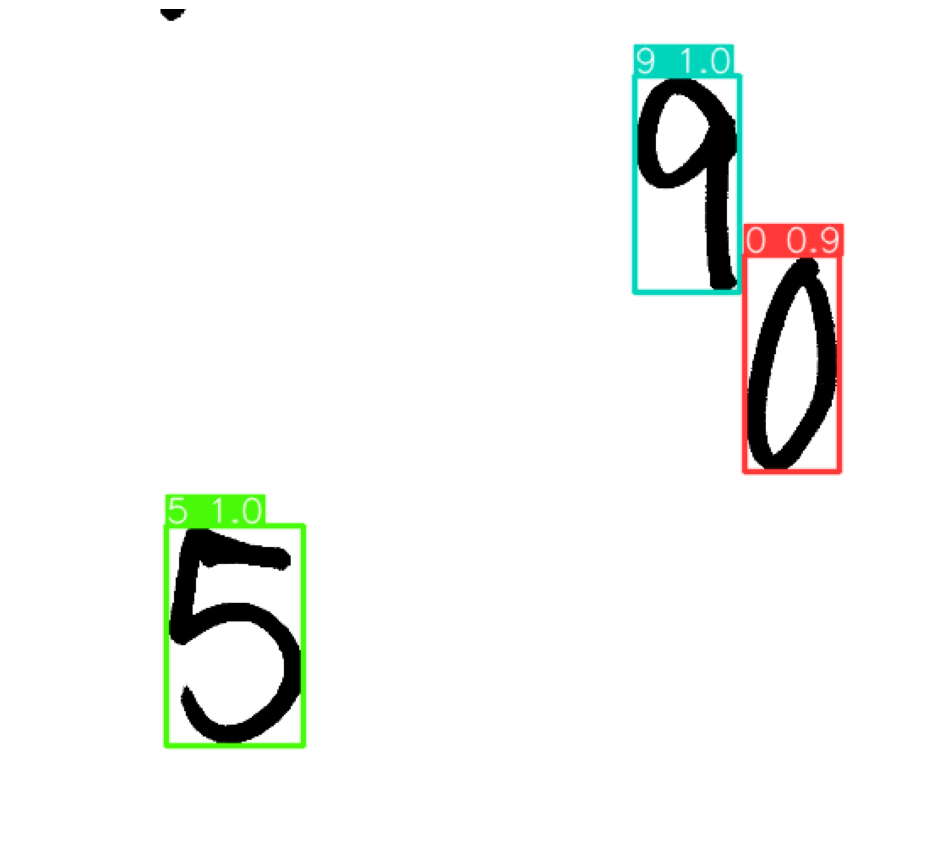

In [9]:
_ = onnx_model(img, 0.7, 0.25).visualize(plot=True)

---
# yolo outputs to nms ONNX

In [32]:
import onnx_graphsurgeon as gs
import numpy as np
import onnx

def create_onnx_NMS(filepath: str="nms.onnx", opset: int = 18):
    """Create ONNX NonMaxSupression which uses YOLO outputs to return boxes, scores and class_ids filtered out with NMS operation"""
    output0 = gs.Variable(name="output0", dtype=np.float32, shape=(1, "4 + num_classes", "num_boxes"))
    output0_transposed = gs.Variable(name="output0_transposed", dtype=np.float32, shape=(1, "num_boxes", "4 + num_classes"))
    node_transpose = gs.Node(op="Transpose", attrs={"perm": [0, 2, 1]}, inputs=[output0], outputs=[output0_transposed])

    shape = gs.Variable(name="shape", dtype=np.int64)
    node_shape = gs.Node(op="Shape", attrs={"start": -1}, inputs=[output0_transposed], outputs=[shape])

    boxes_starts = gs.Constant(name="boxes_starts", values=np.array([0], dtype=np.int64))
    boxes_ends = gs.Constant(name="boxes_ends", values=np.array([4], dtype=np.int64))
    boxes_axes = gs.Constant(name="boxes_axes", values=np.array([2], dtype=np.int64))
    boxes_xywh = gs.Variable(name="boxes_xywh", dtype=np.float32, shape=(1, "num_boxes", 4))
    node_slice_boxes = gs.Node(op="Slice", inputs=[output0_transposed, boxes_starts, boxes_ends, boxes_axes], outputs=[boxes_xywh])

    scores_starts = gs.Constant(name="scores_starts", values=np.array([4], dtype=np.int64))
    scores_ends = shape
    scores_axes = gs.Constant(name="scores_axes", values=np.array([2], dtype=np.int64))
    scores = gs.Variable(name="scores", dtype=np.float32, shape=(1, "num_boxes", None))
    node_slice_scores = gs.Node(op="Slice", inputs=[output0_transposed, scores_starts, scores_ends, scores_axes], outputs=[scores])

    class_scores = gs.Variable(name="class_scores", dtype=np.float32, shape=(1, "num_boxes", 1))
    axes = gs.Constant(name="axes", values=np.array([2], dtype=np.int64))
    node_max_scores = gs.Node(op="ReduceMax", attrs={"keepdims": 1}, inputs=[scores, axes], outputs=[class_scores])

    int64_class_ids = gs.Variable(name="int64_class_ids", dtype=np.int64, shape=(1, "num_boxes", 1))
    node_argmax_scores = gs.Node(op="ArgMax", attrs={"axis": 2, "keepdims": 1}, inputs=[scores], outputs=[int64_class_ids])

    class_ids = gs.Variable(name="class_ids", dtype=np.int32, shape=(1, "num_boxes", 1))
    node_cast_int64_to_int32 = gs.Node(op="Cast", attrs={"to": np.int32}, inputs=[int64_class_ids], outputs=[class_ids])


    class_scores_transposed = gs.Variable(name="class_scores_transposed", dtype=np.float32, shape=(1, 1, "num_boxes"))
    node_class_scores_transpose = gs.Node(op="Transpose", attrs={"perm": [0, 2, 1]}, inputs=[class_scores], outputs=[class_scores_transposed])


    int32_max_output_boxes_per_class = gs.Variable(name="int32_max_output_boxes_per_class", dtype=np.int32, shape=(1, ))
    int64_max_output_boxes_per_class = gs.Variable(name="int64_max_output_boxes_per_class", dtype=np.int64, shape=(1, ))
    node_cast_int32_to_int64 = gs.Node(op="Cast", attrs={"to": np.int64}, inputs=[int32_max_output_boxes_per_class], outputs=[int64_max_output_boxes_per_class])


    iou_threshold = gs.Variable(name="iou_threshold", dtype=np.float32, shape=(1, ))
    score_threshold = gs.Variable(name="score_threshold", dtype=np.float32, shape=(1, ))
    selected_indices = gs.Variable(name="selected_indices", dtype=np.int64, shape=("num_selected_boxes", 3))
    node_nms = gs.Node(
        op="NonMaxSuppression", 
        attrs={"center_point_box": 1}, 
        inputs=[boxes_xywh, class_scores_transposed, int64_max_output_boxes_per_class, iou_threshold, score_threshold], 
        outputs=[selected_indices]
    )

    indices = gs.Constant(name="indices", values=np.array(2, dtype=np.int64))
    selected_box_indices = gs.Variable(name="selected_box_indices", dtype=np.int64, shape=("num_selected_boxes", ))
    node_selected_indices = gs.Node(op="Gather", attrs={"axis": 1}, inputs=[selected_indices, indices], outputs=[selected_box_indices])

    # pick boxes using NMS indices
    squeezed_boxes_xywh = gs.Variable(name="squeezed_boxes_xywh", dtype=np.float32, shape=("num_boxes", 4))
    node_squeezed_boxes_xywh = gs.Node(op="Squeeze", inputs=[boxes_xywh], outputs=[squeezed_boxes_xywh])

    selected_boxes_xywh = gs.Variable(name="selected_boxes_xywh", dtype=np.float32, shape=("num_selected_boxes", 4))
    node_selected_boxes_xywh = gs.Node(op="Gather", attrs={"axis": 0}, inputs=[squeezed_boxes_xywh, selected_box_indices], outputs=[selected_boxes_xywh])

    # pick scores using NMS indices
    squeezed_class_scores = gs.Variable(name="squeezed_class_scores", dtype=np.float32, shape=("num_boxes",))
    node_squeezed_class_scores = gs.Node(op="Squeeze", inputs=[class_scores], outputs=[squeezed_class_scores])

    selected_class_scores = gs.Variable(name="selected_class_scores", dtype=np.float32, shape=("num_selected_boxes",))
    node_selected_class_scores = gs.Node(op="Gather", attrs={"axis": 0}, inputs=[squeezed_class_scores, selected_box_indices], outputs=[selected_class_scores])


    # pick class_ids using NMS indices
    squeezed_class_ids = gs.Variable(name="squeezed_class_ids", dtype=np.int32, shape=("num_boxes",))
    node_squeezed_class_ids = gs.Node(op="Squeeze", inputs=[class_ids], outputs=[squeezed_class_ids])

    selected_class_ids = gs.Variable(name="selected_class_ids", dtype=np.int32, shape=("num_selected_boxes",))
    node_selected_class_ids = gs.Node(op="Gather", attrs={"axis": 0}, inputs=[squeezed_class_ids, selected_box_indices], outputs=[selected_class_ids])

    graph = gs.Graph(
        nodes=[
            node_transpose, 
            node_shape, 
            node_slice_boxes, 
            node_slice_scores, 
            node_max_scores, 
            node_argmax_scores,
            node_cast_int64_to_int32,
            node_class_scores_transpose, 
            node_cast_int32_to_int64,
            node_nms, 
            node_selected_indices,
            node_squeezed_boxes_xywh,
            node_selected_boxes_xywh,
            node_squeezed_class_scores,
            node_selected_class_scores,
            node_squeezed_class_ids,
            node_selected_class_ids
        ], 
        inputs=[output0, int32_max_output_boxes_per_class, iou_threshold, score_threshold], 
        outputs=[selected_boxes_xywh, selected_class_scores, selected_class_ids], 
        opset=opset
    )
    onnx.save(gs.export_onnx(graph), filepath)

In [31]:
create_onnx_NMS(filepath="full_nms.onnx", opset=18)

In [192]:
outputs_transposed = outputs.transpose(0, 2, 1)          # V

boxes_xywh = outputs_transposed[..., :4]      # V
class_scores = outputs_transposed[..., 4:]    # V

scores = class_scores.max(axis=2, keepdims=True) # V
scores = scores.transpose(0, 2, 1)  # V

class_ids = class_scores.argmax(axis=2).squeeze()

iou_threshold = np.array([0.7], dtype=np.float32)
score_threshold = np.array([0.25], dtype=np.float32)

pad_x, pad_y = pad
w = onnx_model.input_w - pad_x * 2
h = onnx_model.input_h - pad_y * 2

boxes_xywh[:, :, 0] -= pad_x
boxes_xywh[:, :, 1] -= pad_y

boxes_xywhn = np.divide(boxes_xywh, np.array([w, h, w, h]))

In [27]:
pre_nms = ort.InferenceSession("full_nms.onnx", providers=["CUDAExecutionProvider", "CPUExecutionProvider"])

In [28]:
pre_nms_data = pre_nms.run(
    ["selected_boxes_xywh", "selected_class_scores", "selected_class_ids"], 
    {
        "output0": outputs, 
        "int32_max_output_boxes_per_class": np.array([100], dtype=np.int32),
        'iou_threshold': np.array([0.7], dtype=np.float32), 
        'score_threshold': np.array([0.25], dtype=np.float32)
    }
)

In [29]:
pre_nms_data

[array([[      186.4,      62.237,      29.219,      59.791],
        [      62.26,      186.25,      37.847,      60.953],
        [     215.28,      111.26,      26.218,       59.98]], dtype=float32),
 array([    0.99841,     0.99451,     0.86349], dtype=float32),
 array([9, 5, 0], dtype=int32)]

In [193]:
preds = nms.run(
    None, 
    {
        "boxes": boxes, 
        "scores": scores, 
        "max_output_boxes_per_class": np.array([100], dtype=np.int64),
        "iou_threshold": iou_threshold,
        "score_threshold": score_threshold
    }
)[0]
onnx_idxs = preds[:, 2].tolist()

In [194]:
mask = scores.squeeze() > score_threshold[0]
local_idxs = non_maximum_supression(xywh2xyxy(boxes_xywhn.squeeze()[mask]), scores.squeeze()[mask], iou_threshold[0])

In [195]:
onnx_boxes = boxes_xywhn.squeeze()[onnx_idxs]
onnx_classes = class_ids[onnx_idxs]
onnx_scores = scores.squeeze()[onnx_idxs]

In [196]:
local_boxes = boxes_xywhn.squeeze()[mask][local_idxs]
local_classes = class_ids[mask][local_idxs]
local_scores = scores.squeeze()[mask][local_idxs]

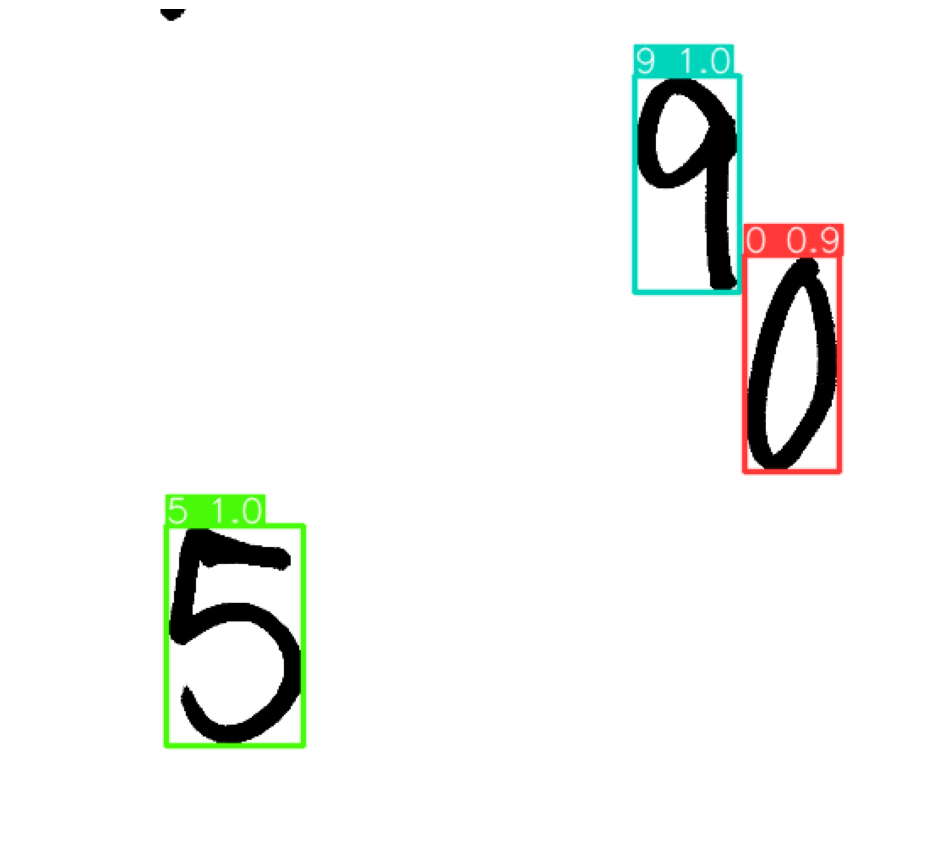

In [197]:
_ = plot_yolo_labels(img, onnx_boxes, onnx_classes, onnx_scores, plot=True)

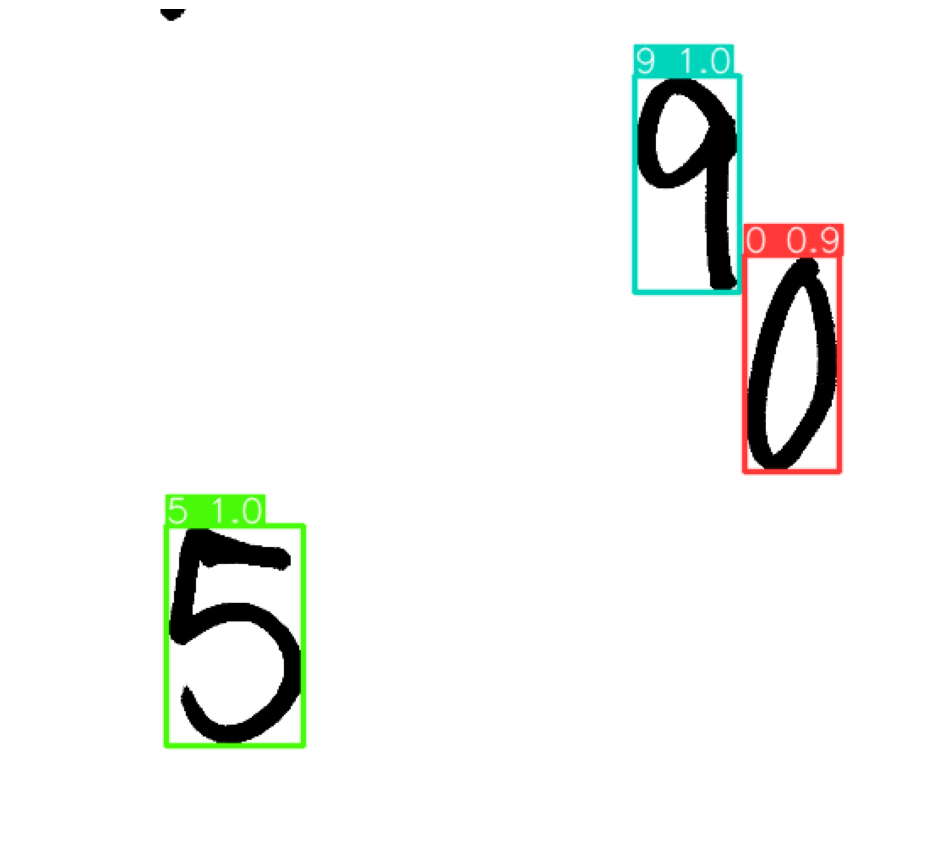

In [198]:
_ = plot_yolo_labels(img, local_boxes, local_classes, local_scores, plot=True)